In [1]:
from obspy.core import Stream, read, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path

In [4]:
path_to_files = '/Users/sydneydybing/StrainProject/2024/'

earthquakes = pd.read_csv(path_to_files + 'M6_catalog_2004-2024.csv', dtype = str)

weird_events_only = False
if weird_events_only:
    earthquakes = earthquakes.iloc[[4,15]]
    
redo_picks = True
if redo_picks:
    earthquakes = earthquakes.iloc[[3,5,6,8,10,17,19,20,21,24,25,26,27,29]]

origin_times = earthquakes.time.values
mags = earthquakes.mag.values

bsm_mda = pd.read_csv(path_to_files + 'bsm_metadata.csv')
NA_only = bsm_mda.loc[bsm_mda['LONG'] < -110]
stas = NA_only['BNUM'].values

eqs_test = earthquakes[4:5]
ots_test = origin_times[4:5]
mags_test = mags[4:5]
rows_for_extra_times = [8,9,14,16]

In [7]:
earthquakes

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
3,2021-12-20T20:10:31.310Z,40.3901667,-124.298,27.04,6.2,mw,33,170,0.06557,0.13,...,2022-12-30T01:11:35.632Z,"7km N of Petrolia, CA",earthquake,0.46,0.34,NaN,0,reviewed,nc,nc
5,2020-05-15T11:03:27.176Z,38.1689,-117.8497,2.7,6.5,ml,27,55.79,0.357,0.2669,...,2023-08-25T20:46:08.292Z,"Monte Cristo Range, NV Earthquake",earthquake,NaN,2.1,NaN,NaN,reviewed,nn,nn
6,2020-03-31T23:52:30.781Z,44.4646,-115.1175,12.06,6.5,mww,NaN,31,0.885,0.66,...,2023-11-27T02:38:57.327Z,"Stanley, Idaho",earthquake,8.5,3.8,0.021,212,reviewed,us,us
8,2019-12-23T20:56:23.555Z,50.5169,-129.7573,10,6,mww,NaN,99,1.042,1.05,...,2020-03-07T17:47:53.040Z,"189 km W of Port McNeill, Canada",earthquake,5.7,1.8,0.038,66,reviewed,us,us
10,2019-08-29T15:07:58.646Z,43.5425,-127.8817,10,6.3,mww,NaN,31,2.678,1.17,...,2021-08-14T16:56:05.720Z,"285 km W of Bandon, Oregon",earthquake,6.9,1.8,0.04,60,reviewed,us,us
17,2018-08-22T09:31:45.530Z,43.5637,-127.7166,10,6.2,mww,NaN,67,2.668,0.73,...,2022-05-03T19:27:59.600Z,"272 km W of Bandon, Oregon",earthquake,7.1,1.8,0.031,97,reviewed,us,us
19,2014-08-24T10:20:44.070Z,38.2151667,-122.3123333,11.12,6.02,mw,369,28,0.03604,0.18,...,2022-05-03T18:17:55.653Z,South Napa,earthquake,0.11,0.15,NaN,0,reviewed,nc,nc
20,2014-04-24T03:10:10.150Z,49.6388,-127.7316,10,6.5,mww,NaN,NaN,NaN,0.85,...,2022-08-06T23:23:06.892Z,"107 km WSW of Vernon, Canada",earthquake,NaN,1.7,NaN,NaN,reviewed,pgc,us
21,2014-03-10T05:18:13.430Z,40.8286667,-125.1338333,16.441,6.8,mw,112,229,0.6568,0.15,...,2022-09-24T19:42:07.982Z,"77 km WNW of Indianola, California",earthquake,0.64,1.88,NaN,5,reviewed,nc,nc
24,2012-12-14T10:36:01.590Z,31.095,-119.66,13,6.3,mww,760,20.9,NaN,1.29,...,2022-08-08T22:41:13.593Z,"279 km SSW of Avalon, California",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us


Earthquake 1/14


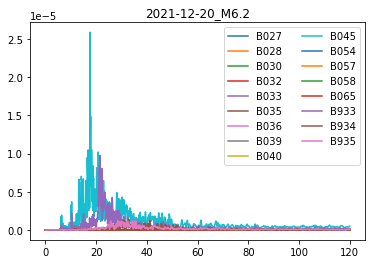

Earthquake 2/14


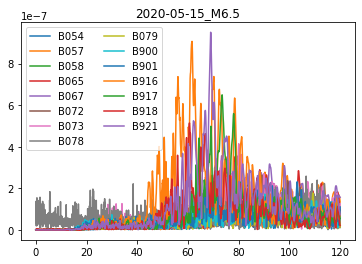

Earthquake 3/14


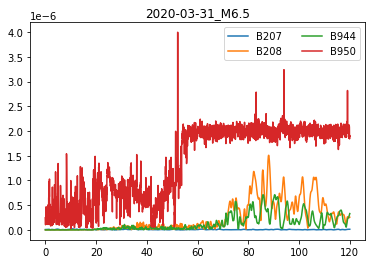

Earthquake 4/14
No data for 2019-12-23_M6
Earthquake 5/14


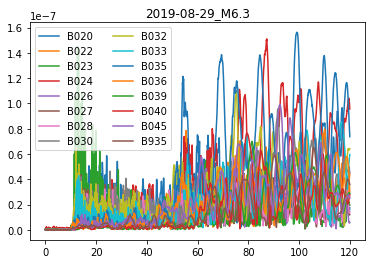

Earthquake 6/14


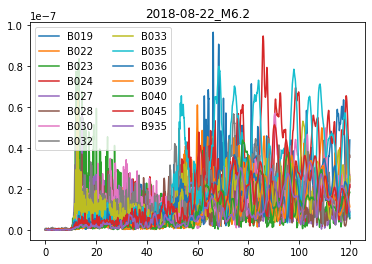

Earthquake 7/14
Skipping 2014-08-24 B076


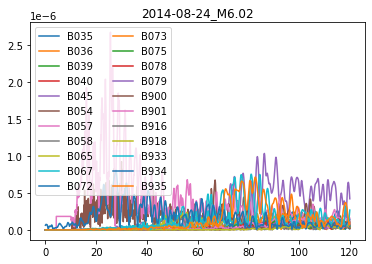

Earthquake 8/14


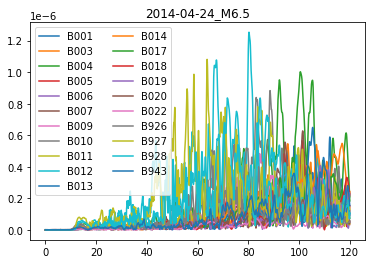

Earthquake 9/14
No data for 2014-03-10T05_M6.8
Earthquake 10/14
No data for 2012-12-14T10_M6.3
Earthquake 11/14


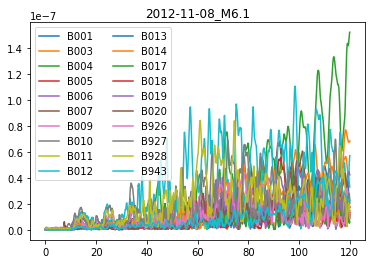

Earthquake 12/14


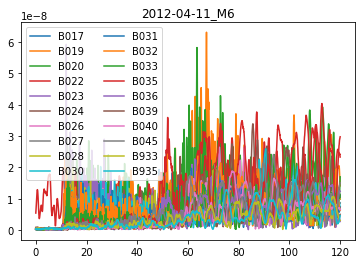

Earthquake 13/14


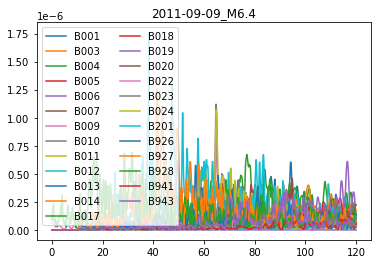

Earthquake 14/14


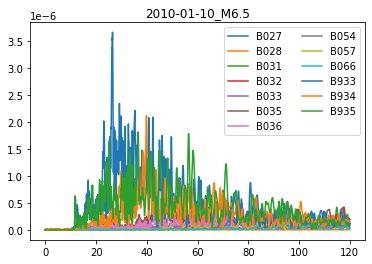

In [8]:
for idx in range(len(earthquakes)):
    
    no_data = False
    ot = origin_times[idx]
    print('Earthquake ' + str(idx+1) + '/' + str(len(mags)))
    
    if idx in rows_for_extra_times:
        cut_ot = ot[:13]
    else:
        cut_ot = ot[:10]
        
    try:
    
        pick_path = path_to_files + 'seismic_data/processed/' + str(cut_ot) + '_M' + str(mags[idx]) + '/picks'
        pick_file = np.genfromtxt(pick_path, dtype = str)
        pick_file_stainfo = pick_file[:,3]

        pick_file_stas = []

        for idx2 in range(len(pick_file_stainfo)):

            pick_file_sta = pick_file_stainfo[idx2].split('.')[1]
            pick_file_stas.append(pick_file_sta)

        pick_file_stas = np.array(pick_file_stas)
    
    except:
        print('No data for ' + str(cut_ot) + '_M' + str(mags[idx]))
        no_data = True
        pass
    
    for sta in stas:
        
        try:
        
            i = np.where(pick_file_stas == sta)[0]
            pick_date = pick_file[i,0][0]
            pick_time = pick_file[i,1][0]
            pick_datetime = UTCDateTime(str(pick_date) + 'T' + str(pick_time) + 'Z')

            starttime = pick_datetime - 10 # 10 seconds before pick time
            endtime = starttime + 120 # full trace will be 2 minutes long

            RMS = read(path_to_files + 'strain_data/rms/' + str(cut_ot) + '_M' + str(mags[idx]) + '/' + str(sta) + '.mseed')
    #         RMS.plot()

            RMS_trim = RMS.trim(starttime = starttime, endtime = endtime, pad = True, fill_value = 0)
    #         RMS_trim.plot()

            # Extracting just the RMS data, now trimmed properly, and saving it to a 
            # new miniSEED file.

            RMS_times_trim = RMS_trim[0].times()
            RMS_data_trim = RMS_trim[0].data
            RMS_trim[0].stats.channel = 'tBSR'
            
            # Plot stations, but avoid plotting the weird stations for the two problem earthquakes
            
            if idx == 4 and sta == 'B072' or sta == 'B076':
                print('Skipping ' + str(cut_ot) + ' ' + str(sta))
                
            elif idx == 15 and sta == 'B928':
                print('Skipping ' + str(cut_ot) + ' ' + str(sta))
                
            else:
                plt.title(str(cut_ot) + '_M' + str(mags[idx]))
                plt.plot(RMS_times_trim, RMS_data_trim, label = sta)
#             plt.legend()
#             plt.show()

#             Plot after each station
#             if no_data: 
#                 pass
#             else:
#                 plt.legend(ncol = 2)
#                 plt.show()

            # Create folder for the event
            eq_sta_save_dir = path_to_files + 'strain_data/trimmed/' + str(cut_ot) + '_M' + str(mags[idx]) + '/'
    #                 print(eq_sta_save_dir)
            if os.path.isdir(eq_sta_save_dir):
                pass
            else:
                os.makedirs(eq_sta_save_dir)

            RMS_trim.write(eq_sta_save_dir + sta + '.mseed', format = 'MSEED')
            
        except:
            pass
    
    # Plot after each earthquake
    if no_data: 
        pass
    else:
        plt.legend(ncol = 2)
        plt.show()  